In [43]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from hmmlearn import hmm as hmm_model  # Renamed to avoid conflict
from hmmlearn.hmm import CategoricalHMM  # use this instead of MultinomialHMM

In [44]:
class HiddenMarkovModel:
    def __init__(self, transition_prob, emission_prob, initial_prob):
        self.transition_prob = transition_prob
        self.emission_prob = emission_prob
        self.initial_prob = initial_prob
        self.num_states = transition_prob.shape[0]
        self.num_obs = emission_prob.shape[1]

    def forward(self, observations):
        T = len(observations)
        alpha = np.zeros((T, self.num_states))
        alpha[0] = self.initial_prob * self.emission_prob[:, observations[0]]

        for t in range(1, T):
            for j in range(self.num_states):
                alpha[t, j] = np.dot(alpha[t - 1], self.transition_prob[:, j]) * self.emission_prob[j, observations[t]]

        return alpha

    def backward(self, observations):
        T = len(observations)
        beta = np.zeros((T, self.num_states))
        beta[-1] = 1

        for t in range(T - 2, -1, -1):
            for i in range(self.num_states):
                beta[t, i] = np.sum(
                    self.transition_prob[i, :] *
                    self.emission_prob[:, observations[t + 1]] *
                    beta[t + 1]
                )

        return beta


    def viterbi(self, observations):
        # Convert parameters to hmmlearn-compatible format
        model = CategoricalHMM(n_components=self.num_states, init_params="")
        model.startprob_ = self.initial_prob
        model.transmat_ = self.transition_prob
        model.emissionprob_ = self.emission_prob

        # hmmlearn expects observations to be a 2D array
        observations = np.array(observations).reshape(-1, 1)
        logprob, states = model.decode(observations, algorithm="viterbi")

        return states, np.exp(logprob)



    def output_sequence_probability(self, observations):
        alpha = self.forward(observations)
        beta = self.backward(observations)

        prob_forward = np.sum(alpha[-1])
        prob_backward = np.sum(self.initial_prob * self.emission_prob[:, observations[0]] * beta[0])

        return prob_forward, prob_backward

    def visualize(self):
        G = nx.MultiDiGraph()

        # Add nodes for each state
        for i in range(self.num_states):
            label = f'State {i}\nInit: {self.initial_prob[i]:.2f}'
            for k in range(self.num_obs):
                label += f'\nObs {k}: {self.emission_prob[i][k]:.2f}'
            G.add_node(i, label=label)

        # Add edges for transitions between states, including self-loops
        for i in range(self.num_states):
            for j in range(self.num_states):
                G.add_edge(i, j, label=f'{self.transition_prob[i][j]:.2f}')
                if i == j:
                    G.add_edge(i, i, label=f'{self.transition_prob[i][i]:.2f}')

        pos = nx.spring_layout(G, scale=30)
        node_labels = nx.get_node_attributes(G, 'label')
        edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}

        nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=2000,
                node_color='green', font_size=8, font_weight='bold')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.title("Hidden Markov Model")
        plt.show()

Forward Procedure:
[[0.27     0.14    ]
 [0.1719   0.0438  ]
 [0.010347 0.089784]]

Backward Procedure:
[[0.2545 0.2244]
 [0.45   0.52  ]
 [1.     1.    ]]

Probability of sequence (Forward): 0.100131
Probability of sequence (Backward): 0.10013100000000001

Most likely state sequence: [0 0 1]
Probability of the sequence: 0.0486

Most likely state sequence (indices): [0 0 1]
Most likely state sequence (labels): ['State 0', 'State 0', 'State 1']
Probability of the sequence: 0.0486


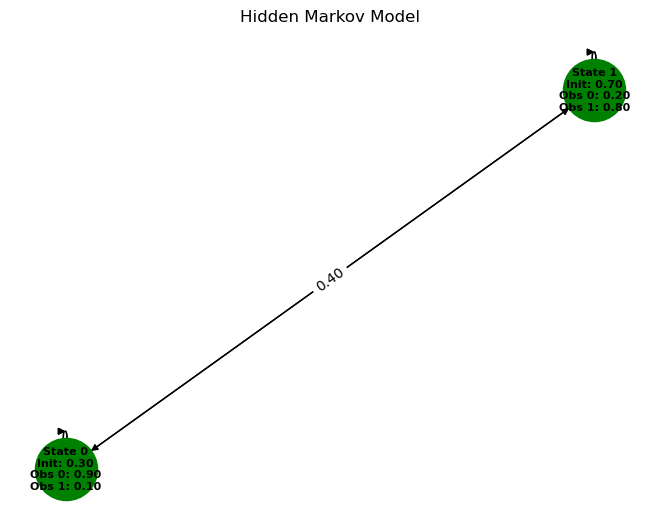

In [45]:
# Example usage
if __name__ == "__main__":
    transition_prob = np.array([[0.5, 0.5],  # From Rainy to Rainy/Sunny
                                [0.4, 0.6]]) # From Sunny to Rainy/Sunny

    emission_prob = np.array([[0.9, 0.1],  # Rainy -> Umbrella / No Umbrella
                              [0.2, 0.8]]) # Sunny -> Umbrella / No Umbrella

    initial_prob = np.array([0.3, 0.7])    # Start more likely with Rainy

    # Observation sequence: Umbrella, Umbrella, No Umbrella
    observations = [0, 0, 1]

    hmm = HiddenMarkovModel(transition_prob, emission_prob, initial_prob)

    print("Forward Procedure:")
    print(hmm.forward(observations))

    print("\nBackward Procedure:")
    print(hmm.backward(observations))

    prob_fwd, prob_bwd = hmm.output_sequence_probability(observations)
    print("\nProbability of sequence (Forward):", prob_fwd)
    print("Probability of sequence (Backward):", prob_bwd)

    states, prob = hmm.viterbi(observations)
    print("\nMost likely state sequence:", states)
    print("Probability of the sequence:", prob)

    states, prob = hmm.viterbi(observations)
    print("\nMost likely state sequence (indices):", states)
    print("Most likely state sequence (labels):", [f"State {s}" for s in states])
    print("Probability of the sequence:", prob)

    
    hmm.visualize()

Forward Procedure:
 [[0.3      0.06     0.02    ]
 [0.0224   0.0306   0.0378  ]
 [0.007674 0.01709  0.006208]]

Backward Procedure:
 [[0.0681 0.1206 0.1653]
 [0.33   0.4    0.3   ]
 [1.     1.     1.    ]]

Probability of sequence (Forward): 0.030972
Probability of sequence (Backward): 0.030971999999999996

Most likely state sequence (indices): [0 1 1]
Most likely state sequence (labels): ['Cold', 'Warm', 'Warm']
Probability of the sequence: 0.005400000000000001


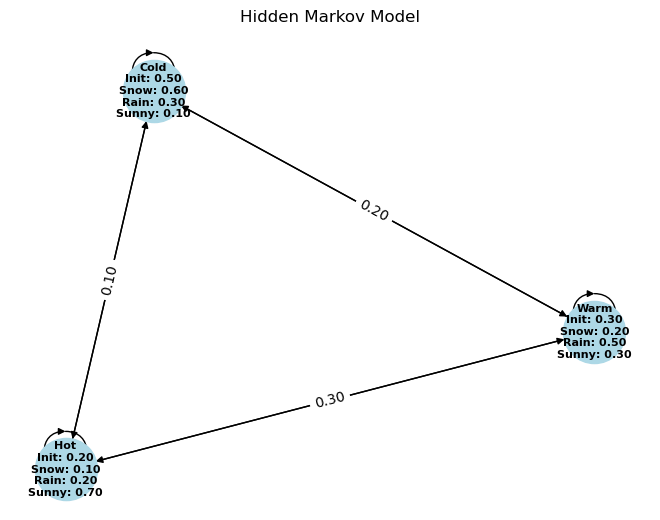

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from hmmlearn.hmm import CategoricalHMM

class HiddenMarkovModel:
    def __init__(self, transition_prob, emission_prob, initial_prob, state_labels=None, obs_labels=None):
        self.transition_prob = transition_prob
        self.emission_prob = emission_prob
        self.initial_prob = initial_prob
        self.num_states = transition_prob.shape[0]
        self.num_obs = emission_prob.shape[1]
        self.state_labels = state_labels or [f"State {i}" for i in range(self.num_states)]
        self.obs_labels = obs_labels or [f"Obs {i}" for i in range(self.num_obs)]

    def forward(self, observations):
        T = len(observations)
        alpha = np.zeros((T, self.num_states))
        alpha[0] = self.initial_prob * self.emission_prob[:, observations[0]]

        for t in range(1, T):
            for j in range(self.num_states):
                alpha[t, j] = np.dot(alpha[t - 1], self.transition_prob[:, j]) * self.emission_prob[j, observations[t]]
        return alpha

    def backward(self, observations):
        T = len(observations)
        beta = np.zeros((T, self.num_states))
        beta[-1] = 1
        for t in range(T - 2, -1, -1):
            for i in range(self.num_states):
                beta[t, i] = np.sum(
                    self.transition_prob[i, :] *
                    self.emission_prob[:, observations[t + 1]] *
                    beta[t + 1]
                )
        return beta

    def viterbi(self, observations):
        model = CategoricalHMM(n_components=self.num_states, init_params="")
        model.startprob_ = self.initial_prob
        model.transmat_ = self.transition_prob
        model.emissionprob_ = self.emission_prob
        observations = np.array(observations).reshape(-1, 1)
        logprob, states = model.decode(observations, algorithm="viterbi")
        return states, np.exp(logprob)

    def output_sequence_probability(self, observations):
        alpha = self.forward(observations)
        beta = self.backward(observations)
        prob_forward = np.sum(alpha[-1])
        prob_backward = np.sum(self.initial_prob * self.emission_prob[:, observations[0]] * beta[0])
        return prob_forward, prob_backward

    def visualize(self):
        G = nx.MultiDiGraph()
        for i in range(self.num_states):
            label = f'{self.state_labels[i]}\nInit: {self.initial_prob[i]:.2f}'
            for k in range(self.num_obs):
                label += f'\n{self.obs_labels[k]}: {self.emission_prob[i][k]:.2f}'
            G.add_node(i, label=label)

        for i in range(self.num_states):
            for j in range(self.num_states):
                G.add_edge(i, j, label=f'{self.transition_prob[i][j]:.2f}')

        pos = nx.spring_layout(G, seed=42)
        node_labels = nx.get_node_attributes(G, 'label')
        edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}

        nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=2000,
                node_color='lightblue', font_size=8, font_weight='bold')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.title("Hidden Markov Model")
        plt.show()


# === Example usage ===
if __name__ == "__main__":
    state_labels = ['Cold', 'Warm', 'Hot']
    obs_labels = ['Snow', 'Rain', 'Sunny']

    # 3x3 transition matrix
    transition_prob = np.array([
        [0.7, 0.2, 0.1],
        [0.2, 0.6, 0.2],
        [0.1, 0.3, 0.6]
    ])

    # 3x3 emission matrix
    emission_prob = np.array([
        [0.6, 0.3, 0.1],  # Cold
        [0.2, 0.5, 0.3],  # Warm
        [0.1, 0.2, 0.7]   # Hot
    ])

    # Initial probabilities
    initial_prob = np.array([0.5, 0.3, 0.2])

    # Observation sequence: Snow (0), Sunny (2), Rain (1)
    observations = [0, 2, 1]

    hmm = HiddenMarkovModel(transition_prob, emission_prob, initial_prob,
                            state_labels=state_labels, obs_labels=obs_labels)

    print("Forward Procedure:\n", hmm.forward(observations))
    print("\nBackward Procedure:\n", hmm.backward(observations))

    prob_fwd, prob_bwd = hmm.output_sequence_probability(observations)
    print("\nProbability of sequence (Forward):", prob_fwd)
    print("Probability of sequence (Backward):", prob_bwd)

    states, prob = hmm.viterbi(observations)
    print("\nMost likely state sequence (indices):", states)
    print("Most likely state sequence (labels):", [state_labels[s] for s in states])
    print("Probability of the sequence:", prob)

    hmm.visualize()


Forward:
 [[0.3      0.06     0.02    ]
 [0.0224   0.0306   0.0378  ]
 [0.007674 0.01709  0.006208]]

Backward:
 [[0.0681 0.1206 0.1653]
 [0.33   0.4    0.3   ]
 [1.     1.     1.    ]]

Sequence Probability (Forward): 0.030972000000000003
Sequence Probability (Backward): 0.030971999999999996

Most probable state sequence: ['Cold', 'Warm', 'Warm']
Probability of the most probable sequence: 0.005399999999999999


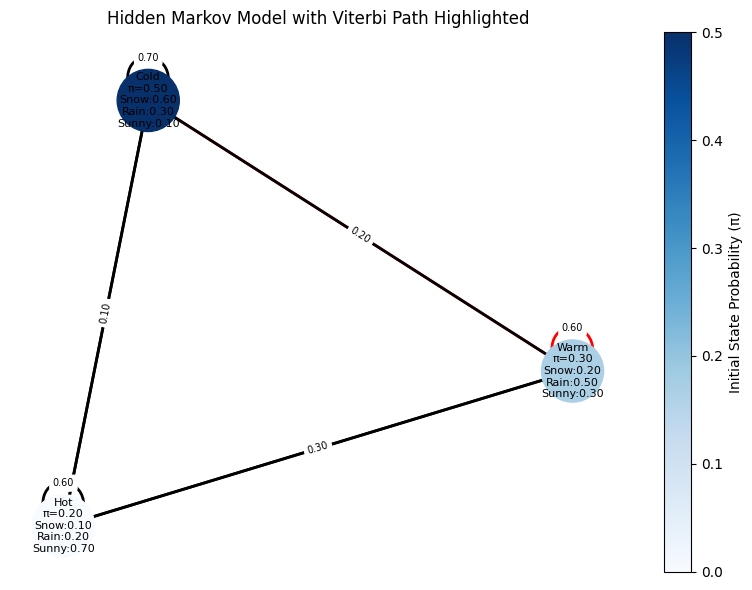

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

class HiddenMarkovModel:
    def __init__(self, A, B, pi, state_labels=None, obs_labels=None):
        # A: Transition matrix (NxN)
        # B: Emission matrix (NxM)
        # pi: Initial state probabilities (N)
        self.A = A
        self.B = B
        self.pi = pi
        self.N = len(A)  # Number of states
        self.M = B.shape[1]  # Number of observations
        self.states = state_labels or [f"S{i}" for i in range(self.N)]
        self.observations = obs_labels or [f"O{i}" for i in range(self.M)]

    def forward(self, obs):
        T = len(obs)
        alpha = np.zeros((T, self.N))
        alpha[0] = self.pi * self.B[:, obs[0]]
        for t in range(1, T):
            alpha[t] = (alpha[t-1] @ self.A) * self.B[:, obs[t]]
        return alpha

    def backward(self, obs):
        T = len(obs)
        beta = np.zeros((T, self.N))
        beta[-1] = 1
        for t in range(T-2, -1, -1):
            beta[t] = (self.A @ (self.B[:, obs[t+1]] * beta[t+1]))
        return beta

    def viterbi(self, obs):
        T = len(obs)
        delta = np.zeros((T, self.N))  # Stores the max probability at each state
        psi = np.zeros((T, self.N), int)  # Stores the backpointer for each state
        
        # Initialization step: first observation
        delta[0] = self.pi * self.B[:, obs[0]]
        
        # Recursion: For each time step
        for t in range(1, T):
            for j in range(self.N):
                prob = delta[t-1] * self.A[:, j]  # Transition probabilities from previous states
                psi[t, j] = np.argmax(prob)  # Store the state with max probability
                delta[t, j] = np.max(prob) * self.B[j, obs[t]]  # Multiply by emission probabilities
        
        # Backtracking: Trace the most likely state sequence
        path = np.zeros(T, int)
        path[-1] = np.argmax(delta[-1])  # Take the last state with the highest probability
        for t in range(T - 2, -1, -1):
            path[t] = psi[t + 1, path[t + 1]]  # Follow the backpointer
        
        return path, np.max(delta[-1])  # Return the path and its probability

    def sequence_prob(self, obs):
        alpha = self.forward(obs)
        beta = self.backward(obs)
        # Forward-backward probabilities
        return np.sum(alpha[-1]), np.sum(self.pi * self.B[:, obs[0]] * beta[0])

    def visualize(self, path=None):
        
        G = nx.DiGraph()
    
        # Add nodes with π and emission labels
        for i in range(self.N):
            emissions = "\n".join(f'{self.observations[k]}:{self.B[i][k]:.2f}' for k in range(self.M))
            label = f'{self.states[i]}\nπ={self.pi[i]:.2f}\n{emissions}'
            G.add_node(i, label=label, pi=self.pi[i])
    
        # Add directed edges with transition probabilities
        for i in range(self.N):
            for j in range(self.N):
                G.add_edge(i, j, label=f'{self.A[i][j]:.2f}')
    
        pos = nx.spring_layout(G, seed=42)
        node_labels = nx.get_node_attributes(G, 'label')
        node_colors = [G.nodes[i]['pi'] for i in G.nodes()]
        max_pi = max(node_colors)
        node_colors = [c / max_pi for c in node_colors]
    
        fig, ax = plt.subplots(figsize=(8, 6))
    
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, cmap=plt.cm.Blues, ax=ax)
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, ax=ax)
    
        edge_labels = nx.get_edge_attributes(G, 'label')
    
        # === Build the path edges set for fast lookup ===
        path_edges = set()
        if path is not None:
            for k in range(len(path) - 1):
                path_edges.add((path[k], path[k + 1]))
    
        # Color edges: red if in path_edges
        edge_colors = ['red' if (u, v) in path_edges else 'black' for u, v in G.edges()]
    
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2, arrows=True, arrowstyle='-|>', ax=ax)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, ax=ax)
    
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0, vmax=max_pi))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label("Initial State Probability (π)")
    
        ax.set_title("Hidden Markov Model with Viterbi Path Highlighted")
        ax.axis('off')
        plt.tight_layout()
        plt.show()




# === Example Usage ===
if __name__ == "__main__":
    # Transition matrix A (NxN)
    A = np.array([[0.7, 0.2, 0.1],
                  [0.2, 0.6, 0.2],
                  [0.1, 0.3, 0.6]])
    
    # Emission matrix B (NxM)
    B = np.array([[0.6, 0.3, 0.1],
                  [0.2, 0.5, 0.3],
                  [0.1, 0.2, 0.7]])
    
    # Initial state probabilities (N)
    pi = np.array([0.5, 0.3, 0.2])
    
    # Observation sequence (e.g., Snow (0), Sunny (2), Rain (1))
    obs_seq = [0, 2, 1]
    
    # Labels for states and observations
    labels = ['Cold', 'Warm', 'Hot']
    obs_labels = ['Snow', 'Rain', 'Sunny']

    # Initialize the Hidden Markov Model
    hmm = HiddenMarkovModel(A, B, pi, labels, obs_labels)

    # Calculate Forward and Backward probabilities
    print("Forward:\n", hmm.forward(obs_seq))
    print("\nBackward:\n", hmm.backward(obs_seq))

    # Calculate sequence probability (Forward & Backward)
    pf, pb = hmm.sequence_prob(obs_seq)
    print("\nSequence Probability (Forward):", pf)
    print("Sequence Probability (Backward):", pb)

    # Run Viterbi to find the most probable state sequence
    states, prob = hmm.viterbi(obs_seq)
    print("\nMost probable state sequence:", [labels[s] for s in states])
    print("Probability of the most probable sequence:", prob)
    # Run Viterbi


    # Visualize the HMM
    hmm.visualize(states)  # Highlight the best path in red


In [4]:
def visualize(self, path=None):
    import matplotlib.pyplot as plt
    import networkx as nx
    import matplotlib.cm as cm
    import matplotlib.colors as colors

    G = nx.DiGraph()

    # Add nodes with state labels and emission probabilities
    for i in range(self.N):
        label = f'{self.states[i]}\nπ={self.pi[i]:.2f}\n' + "\n".join(
            f'{self.observations[k]}:{self.B[i][k]:.2f}' for k in range(self.M)
        )
        G.add_node(i, label=label)

    # Add edges with transition probabilities
    for i in range(self.N):
        for j in range(self.N):
            G.add_edge(i, j, weight=self.A[i][j])

    # Visualization of nodes and edges
    pos = nx.spring_layout(G, seed=1)
    node_labels = nx.get_node_attributes(G, 'label')
    edge_labels = {(i, j): f'{G[i][j]["weight"]:.2f}' for i, j in G.edges()}

    # Normalize π values for colormap
    norm = colors.Normalize(vmin=min(self.pi), vmax=max(self.pi))
    cmap = cm.get_cmap('Blues')
    node_colors = [cmap(norm(self.pi[i])) for i in range(self.N)]

    # Determine edge colors
    edge_colors = []
    for i, j in G.edges():
        if path and any((path[k] == i and path[k+1] == j) for k in range(len(path) - 1)):
            edge_colors.append('red')
        elif self.A[i][j] == max(self.A[i]):
            edge_colors.append('green')  # Highlight most probable transition
        else:
            edge_colors.append('black')

    # Draw nodes, edges, and labels
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=1800,
            node_color=node_colors, font_size=8, edge_color=edge_colors, width=2)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Hidden Markov Model Visualizaton")
    plt.show()


Forward:
 [[0.3      0.06     0.02    ]
 [0.0224   0.0306   0.0378  ]
 [0.007674 0.01709  0.006208]]

Backward:
 [[0.0681 0.1206 0.1653]
 [0.33   0.4    0.3   ]
 [1.     1.     1.    ]]

Sequence Probability (Forward): 0.030972000000000003
Sequence Probability (Backward): 0.030971999999999996

Most probable state sequence: ['Cold', 'Warm', 'Warm']
Probability of the most probable sequence: 0.005399999999999999


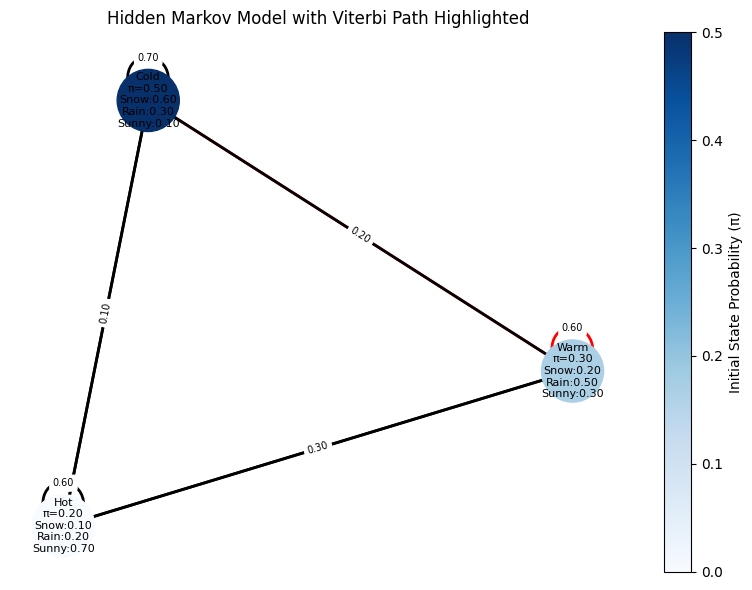

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

class HiddenMarkovModel:
    def __init__(self, A, B, pi, state_labels=None, obs_labels=None):
        # A: Transition matrix (NxN)
        # B: Emission matrix (NxM)
        # pi: Initial state probabilities (N)
        self.A = A
        self.B = B
        self.pi = pi
        self.N = len(A)
        self.M = B.shape[1]
        self.states = state_labels or [f"S{i}" for i in range(self.N)]
        self.observations = obs_labels or [f"O{i}" for i in range(self.M)]

    def forward(self, obs):
        T = len(obs)
        alpha = np.zeros((T, self.N))
        alpha[0] = self.pi * self.B[:, obs[0]]
        for t in range(1, T):
            alpha[t] = (alpha[t - 1] @ self.A) * self.B[:, obs[t]]
        return alpha

    def backward(self, obs):
        T = len(obs)
        beta = np.zeros((T, self.N))
        beta[-1] = 1
        for t in range(T - 2, -1, -1):
            beta[t] = (self.A @ (self.B[:, obs[t + 1]] * beta[t + 1]))
        return beta

    def viterbi(self, obs):
        T = len(obs)
        delta = np.zeros((T, self.N))
        psi = np.zeros((T, self.N), int)
        delta[0] = self.pi * self.B[:, obs[0]]
        for t in range(1, T):
            for j in range(self.N):
                prob = delta[t - 1] * self.A[:, j]
                psi[t, j] = np.argmax(prob)
                delta[t, j] = np.max(prob) * self.B[j, obs[t]]
        path = np.zeros(T, int)
        path[-1] = np.argmax(delta[-1])
        for t in range(T - 2, -1, -1):
            path[t] = psi[t + 1, path[t + 1]]
        return path, np.max(delta[-1])

    def sequence_prob(self, obs):
        alpha = self.forward(obs)
        beta = self.backward(obs)
        return np.sum(alpha[-1]), np.sum(self.pi * self.B[:, obs[0]] * beta[0])

    def visualize(self, path=None):
        G = nx.DiGraph()
        for i in range(self.N):
            emissions = "\n".join(f'{self.observations[k]}:{self.B[i][k]:.2f}' for k in range(self.M))
            label = f'{self.states[i]}\nπ={self.pi[i]:.2f}\n{emissions}'
            G.add_node(i, label=label, pi=self.pi[i])
        for i in range(self.N):
            for j in range(self.N):
                G.add_edge(i, j, label=f'{self.A[i][j]:.2f}')
        pos = nx.spring_layout(G, seed=42)
        node_labels = nx.get_node_attributes(G, 'label')
        node_colors = [G.nodes[i]['pi'] for i in G.nodes()]
        max_pi = max(node_colors)
        node_colors = [c / max_pi for c in node_colors]
        fig, ax = plt.subplots(figsize=(8, 6))
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, cmap=plt.cm.Blues, ax=ax)
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, ax=ax)
        edge_labels = nx.get_edge_attributes(G, 'label')
        path_edges = set()
        if path is not None:
            for k in range(len(path) - 1):
                path_edges.add((path[k], path[k + 1]))
        edge_colors = ['red' if (u, v) in path_edges else 'black' for u, v in G.edges()]
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2, arrows=True, arrowstyle='-|>', ax=ax)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, ax=ax)
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0, vmax=max_pi))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label("Initial State Probability (π)")
        ax.set_title("Hidden Markov Model with Viterbi Path Highlighted")
        ax.axis('off')
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    A = np.array([[0.7, 0.2, 0.1],
                  [0.2, 0.6, 0.2],
                  [0.1, 0.3, 0.6]])
    B = np.array([[0.6, 0.3, 0.1],
                  [0.2, 0.5, 0.3],
                  [0.1, 0.2, 0.7]])
    pi = np.array([0.5, 0.3, 0.2])
    obs_seq = [0, 2, 1]
    labels = ['Cold', 'Warm', 'Hot']
    obs_labels = ['Snow', 'Rain', 'Sunny']
    hmm = HiddenMarkovModel(A, B, pi, labels, obs_labels)
    print("Forward:\n", hmm.forward(obs_seq))
    print("\nBackward:\n", hmm.backward(obs_seq))
    pf, pb = hmm.sequence_prob(obs_seq)
    print("\nSequence Probability (Forward):", pf)
    print("Sequence Probability (Backward):", pb)
    states, prob = hmm.viterbi(obs_seq)
    print("\nMost probable state sequence:", [labels[s] for s in states])
    print("Probability of the most probable sequence:", prob)
    hmm.visualize(states)
